2023-02-08 12:20:44.907952: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


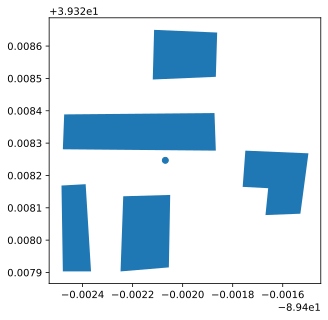

In [1]:
# Hide warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import time
import h5pyd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import geometry
import os

#from dw_tap.process_geojson import get_obstacles
from dw_tap.data_fetching import getData
#from dw_tap.process_geojson import get_candidate
from dw_tap.lom import run_lom
from dw_tap.power_output import estimate_power_output

import shapely.wkt
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'svg'

obstacle_file ="../sites/180-5BuildingsManual.geojson"


#obstacle_file ="../sites/180-3dBuildings1.geojson"


df_places = gpd.read_file(obstacle_file)
# Leave in only relevant columns
df_places = df_places[["height", "geometry"]]

ax=df_places.geometry.plot()

# Need to use better projection
# source of solution: https://gis.stackexchange.com/questions/372564/userwarning-when-trying-to-get-centroid-from-a-polygon-geopandas
df_places_centroid = df_places.dissolve().to_crs('+proj=cea').centroid.to_crs(df_places.crs)
df_places_centroid.geometry.plot(ax=ax);

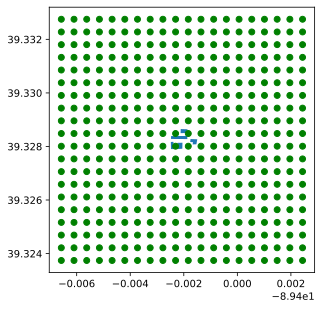

,geometry
0,POINT (-89.40657 39.32374)
1,POINT (-89.40610 39.32374)
2,POINT (-89.40563 39.32374)
3,POINT (-89.40515 39.32374)
4,POINT (-89.40468 39.32374)
...,...
395,POINT (-89.39946 39.33275)
396,POINT (-89.39899 39.33275)
397,POINT (-89.39851 39.33275)
398,POINT (-89.39804 39.33275)


In [2]:
# Creating the grid over site

# Here using 1 degree = 111,000m -- 
# This crude approx should be an appropriate option for point generation
m_per_deg = 111000

site_box_width_m = 1000
site_box_height_m = 1000

# halfs of box / dimensions
lon_delta = (site_box_width_m / m_per_deg ) / 2.0
lat_delta = (site_box_height_m / m_per_deg ) / 2.0

df_places_centroid.geometry.x, df_places_centroid.geometry.y
#print(lon_delta, lat_delta)

# Change this number to change resolution; keep x and y resolutions the same for now
n_points = 20
lon_n, lat_n = (n_points, n_points)
x = np.linspace(df_places_centroid.geometry.x-lon_delta, 
                df_places_centroid.geometry.x+lon_delta, 
                lon_n)
y = np.linspace(df_places_centroid.geometry.y-lat_delta, 
                df_places_centroid.geometry.y+lat_delta, 
                lat_n)
xv, yv = np.meshgrid(x, y)
#xv, yv

# plotting using two arrays, xv and yv, created by meshgrid()
# Probably not the best format for exluding points that fall inside the buildings 

#ax=df_places.geometry.plot()
#df_places_centroid.geometry.plot(ax=ax);
#ax.plot(xv, yv, ls="None", marker=".");
#plt.show()

gridpoints = gpd.GeoDataFrame(
    {"geometry": [geometry.Point(el) for el in zip(xv.flatten(), yv.flatten())]})
#gridpoints.plot();

inside_polygons_index = gpd.sjoin(gridpoints, df_places, op='within').index
outside_polygons_index = [i for i in gridpoints.index if i not in inside_polygons_index]
gridpoints_outside_polygons = gridpoints.loc[outside_polygons_index]

ax=df_places.geometry.plot()
#df_places_centroid.geometry.plot(ax=ax);

#ax.plot(xv, yv, ls="None", marker=".");
gridpoints_outside_polygons.plot(color="green", ax=ax)
plt.show()

display(gridpoints_outside_polygons)

In [3]:
# For testing outside of NREL, load in data from a file
# This isn't quite the same as running getData() for each of the heatmap points
# (because spatial interpolation will change the values slighly)
# but it is close enough for the first pass
atmospheric_df = pd.read_csv("../data/180_heatmap_atmospheric_df.csv")
atmospheric_df

,datetime,ws,wd,temp,pres
0,2007-01-01 00:00:00,7.683119,232.508191,282.541870,98499.850352
1,2007-01-01 01:00:00,8.222278,238.574261,281.693481,98501.451630
2,2007-01-01 02:00:00,6.988345,231.297383,280.445251,98545.683064
3,2007-01-01 03:00:00,8.520537,237.966652,279.526672,98557.756792
4,2007-01-01 04:00:00,8.442824,237.396860,278.693512,98561.814434
...,...,...,...,...,...
3996,2007-06-16 12:00:00,2.858806,206.698108,296.040222,99347.146252
3997,2007-06-16 13:00:00,2.261839,232.444827,297.358612,99409.003116
3998,2007-06-16 14:00:00,2.773922,233.539890,300.227356,99418.447374
3999,2007-06-16 15:00:00,2.964299,229.723320,302.250732,99428.650301


### Below: heatmap for a specific moment in time and showing ws-adjusted (wind estimate after LOM)

In [4]:
# Select indecies for studying (each index corresponds to a timestep in the input atmospheric dataframe)
# Maybe start with a list with a single value and then try a longer list
time_step_ids = [5, 300, 500]

# Along the selected, leave in the ones that will not cause issues: between 0 and length of atmospheric_df
time_step_ids = [id for id in time_step_ids if ((id >= 0) and (id < len(atmospheric_df)))]
time_step_ids

[5, 300, 500]

2023-02-08 12:20:50.880019: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Done with loading ML model.


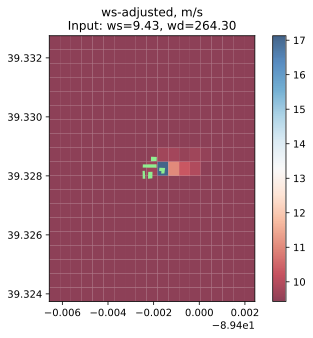

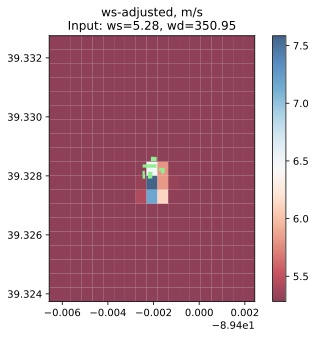

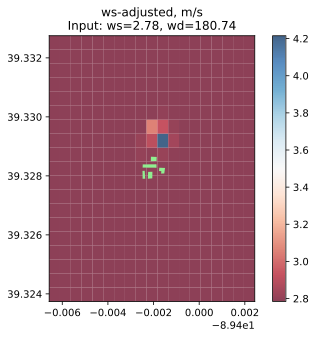

In [5]:
# New way of creating a summary dataframe, one quantity at a time; NO LOM

# Open the wind data "file"
# server endpoint, username, password is found via a config file
# f = h5pyd.File("/nrel/wtk-us.h5", 'r', bucket="nrel-pds-hsds") 

# Replace old files or not
overwrite = True

z_turbine =10  
obstacles_df = df_places   

output_dest = "../output/heatmap-180/"
if not os.path.exists(output_dest):
    os.makedirs(output_dest)

gridpoints_outside_polygons["ws"] = None
gridpoints_outside_polygons["wd"] = None
    
for time_step_id in time_step_ids:
    
    summary_df_cols = ["geometry", "ws-adjusted"]
    summary_df = pd.DataFrame(columns=summary_df_cols)
    summary_df_path = os.path.join(output_dest, "summary.csv")

    if os.path.exists(summary_df_path):
        if not overwrite:
            summary_df = pd.read_csv(summary_df_path)
    
    ### Computing
    
    for idx in gridpoints_outside_polygons.index:

        lat, lon = gridpoints_outside_polygons.at[idx, "geometry"].y, gridpoints_outside_polygons.at[idx, "geometry"].x

        lat_lon_label = str(lat) + "_" + str(lon)
        #print(lat_lon_label)

        ts_df_path = os.path.join(output_dest, lat_lon_label + ".csv")
        #print(ts_df_path)

        if os.path.exists(ts_df_path) and (not overwrite):
            print("This point was already processed. Skipping to the next one (overwrite flag is off)")
            continue

        time_period = str(atmospheric_df["datetime"][0]) + " - " + str(atmospheric_df["datetime"][len(atmospheric_df)-1])

        #gridpoints_outside_polygons.at[idx, "ws"] = ws.tolist()
        #gridpoints_outside_polygons.at[idx, "wd"] = theta.tolist()

        xy_turbine = [np.array([lon, lat])]

        # Instead of passing an entire input dataframe, here we pass in a single row
        predictions_df = \
            run_lom(atmospheric_df.iloc[[time_step_id]].reset_index(), obstacles_df, xy_turbine, z_turbine,
                   check_distance=True)

        predicte_ws = predictions_df.at[0, "ws-adjusted"]
        summary_df.loc[len(summary_df)] = [gridpoints_outside_polygons.at[idx, "geometry"], 
                                          predicte_ws]
        #print(predicte_ws)

    #display(summary_df)

    # Convert strings (possibly loaded from saved file) to shapely point objects
    # for idx in summary_df.index:
    #     el = summary_df["geometry"][idx]
    #     if type(el) == type("string"):
    #         summary_df["geometry"][idx] = shapely.wkt.loads(el)

    ### Visualizing
    
    # following code is based on example from: https://stackoverflow.com/questions/33282368/plotting-a-2d-heatmap
    x_, y_, z_ = [el.x for el in summary_df.geometry], \
                 [el.y for el in summary_df.geometry], \
                  summary_df["ws-adjusted"].tolist()

    # generate 2 2d grids for the x & y bounds
    y, x = np.array(y_).reshape(n_points,-1), np.array(x_).reshape(n_points,-1)
    z = np.array(z_).reshape(n_points,-1)
    # x and y are bounds, so z should be the value *inside* those bounds.
    # Therefore, remove the last value from the z array.
    z = z[:-1, :-1]
    z_min, z_max = z.min(), z.max()
    fig, ax = plt.subplots()
    c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max, alpha=0.75)

    input_ws = atmospheric_df.iloc[[time_step_id]]["ws"].tolist()[0]
    input_wd = atmospheric_df.iloc[[time_step_id]]["wd"].tolist()[0]
    ax.set_title('ws-adjusted, m/s\nInput: ws=%.2f, wd=%.2f' % (input_ws, input_wd))
    ax.set_aspect('equal')
    # set the limits of the plot to the limits of the data
    ax.axis([x.min(), x.max(), y.min(), y.max()])
    fig.colorbar(c, ax=ax)
    df_places.geometry.plot(color='lightgreen', ax=ax)
    plt.show()

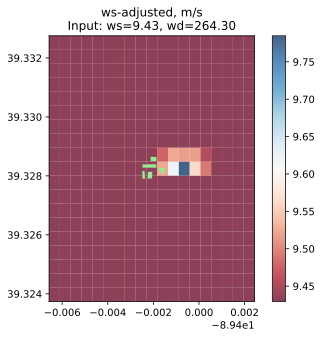

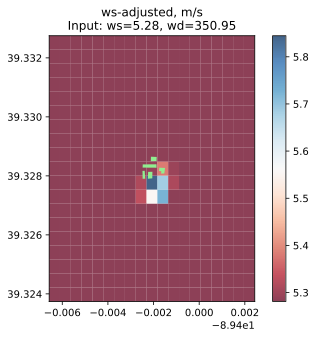

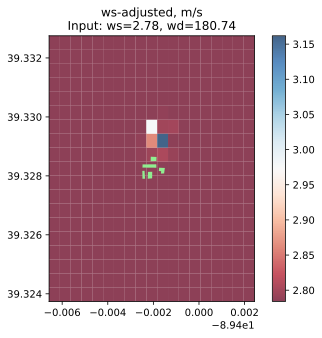

In [6]:
# New way of creating a summary dataframe, one quantity at a time; NO LOM

# Open the wind data "file"
# server endpoint, username, password is found via a config file
# f = h5pyd.File("/nrel/wtk-us.h5", 'r', bucket="nrel-pds-hsds") 

# Replace old files or not
overwrite = True

z_turbine =20  
obstacles_df = df_places   

output_dest = "../output/heatmap-180/"
if not os.path.exists(output_dest):
    os.makedirs(output_dest)

gridpoints_outside_polygons["ws"] = None
gridpoints_outside_polygons["wd"] = None
    
for time_step_id in time_step_ids:
    
    summary_df_cols = ["geometry", "ws-adjusted"]
    summary_df = pd.DataFrame(columns=summary_df_cols)
    summary_df_path = os.path.join(output_dest, "summary.csv")

    if os.path.exists(summary_df_path):
        if not overwrite:
            summary_df = pd.read_csv(summary_df_path)
    
    ### Computing
    
    for idx in gridpoints_outside_polygons.index:

        lat, lon = gridpoints_outside_polygons.at[idx, "geometry"].y, gridpoints_outside_polygons.at[idx, "geometry"].x

        lat_lon_label = str(lat) + "_" + str(lon)
        #print(lat_lon_label)

        ts_df_path = os.path.join(output_dest, lat_lon_label + ".csv")
        #print(ts_df_path)

        if os.path.exists(ts_df_path) and (not overwrite):
            print("This point was already processed. Skipping to the next one (overwrite flag is off)")
            continue

        time_period = str(atmospheric_df["datetime"][0]) + " - " + str(atmospheric_df["datetime"][len(atmospheric_df)-1])

        #gridpoints_outside_polygons.at[idx, "ws"] = ws.tolist()
        #gridpoints_outside_polygons.at[idx, "wd"] = theta.tolist()

        xy_turbine = [np.array([lon, lat])]

        # Instead of passing an entire input dataframe, here we pass in a single row
        predictions_df = \
            run_lom(atmospheric_df.iloc[[time_step_id]].reset_index(), obstacles_df, xy_turbine, z_turbine,
                   check_distance=True)

        predicte_ws = predictions_df.at[0, "ws-adjusted"]
        summary_df.loc[len(summary_df)] = [gridpoints_outside_polygons.at[idx, "geometry"], 
                                          predicte_ws]
        #print(predicte_ws)

    #display(summary_df)

    # Convert strings (possibly loaded from saved file) to shapely point objects
    # for idx in summary_df.index:
    #     el = summary_df["geometry"][idx]
    #     if type(el) == type("string"):
    #         summary_df["geometry"][idx] = shapely.wkt.loads(el)

    ### Visualizing
    
    # following code is based on example from: https://stackoverflow.com/questions/33282368/plotting-a-2d-heatmap
    x_, y_, z_ = [el.x for el in summary_df.geometry], \
                 [el.y for el in summary_df.geometry], \
                  summary_df["ws-adjusted"].tolist()

    # generate 2 2d grids for the x & y bounds
    y, x = np.array(y_).reshape(n_points,-1), np.array(x_).reshape(n_points,-1)
    z = np.array(z_).reshape(n_points,-1)
    # x and y are bounds, so z should be the value *inside* those bounds.
    # Therefore, remove the last value from the z array.
    z = z[:-1, :-1]
    z_min, z_max = z.min(), z.max()
    fig, ax = plt.subplots()
    c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max, alpha=0.75)

    input_ws = atmospheric_df.iloc[[time_step_id]]["ws"].tolist()[0]
    input_wd = atmospheric_df.iloc[[time_step_id]]["wd"].tolist()[0]
    ax.set_title('ws-adjusted, m/s\nInput: ws=%.2f, wd=%.2f' % (input_ws, input_wd))
    ax.set_aspect('equal')
    # set the limits of the plot to the limits of the data
    ax.axis([x.min(), x.max(), y.min(), y.max()])
    fig.colorbar(c, ax=ax)
    df_places.geometry.plot(color='lightgreen', ax=ax)
    plt.show()

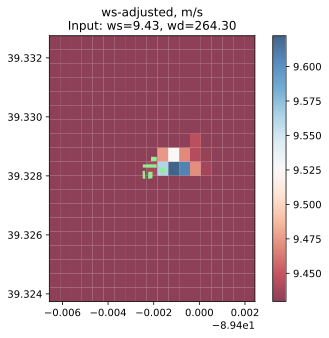

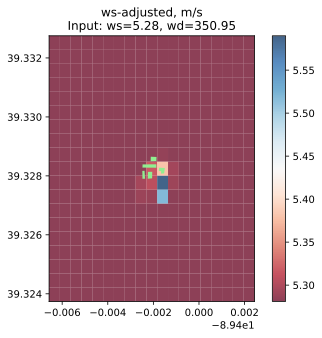

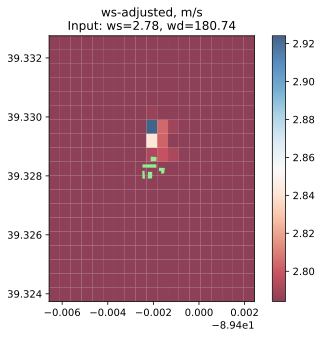

In [7]:
# New way of creating a summary dataframe, one quantity at a time; NO LOM

# Open the wind data "file"
# server endpoint, username, password is found via a config file
# f = h5pyd.File("/nrel/wtk-us.h5", 'r', bucket="nrel-pds-hsds") 

# Replace old files or not
overwrite = True

z_turbine =30  
obstacles_df = df_places   

output_dest = "../output/heatmap-180/"
if not os.path.exists(output_dest):
    os.makedirs(output_dest)

gridpoints_outside_polygons["ws"] = None
gridpoints_outside_polygons["wd"] = None
    
for time_step_id in time_step_ids:
    
    summary_df_cols = ["geometry", "ws-adjusted"]
    summary_df = pd.DataFrame(columns=summary_df_cols)
    summary_df_path = os.path.join(output_dest, "summary.csv")

    if os.path.exists(summary_df_path):
        if not overwrite:
            summary_df = pd.read_csv(summary_df_path)
    
    ### Computing
    
    for idx in gridpoints_outside_polygons.index:

        lat, lon = gridpoints_outside_polygons.at[idx, "geometry"].y, gridpoints_outside_polygons.at[idx, "geometry"].x

        lat_lon_label = str(lat) + "_" + str(lon)
        #print(lat_lon_label)

        ts_df_path = os.path.join(output_dest, lat_lon_label + ".csv")
        #print(ts_df_path)

        if os.path.exists(ts_df_path) and (not overwrite):
            print("This point was already processed. Skipping to the next one (overwrite flag is off)")
            continue

        time_period = str(atmospheric_df["datetime"][0]) + " - " + str(atmospheric_df["datetime"][len(atmospheric_df)-1])

        #gridpoints_outside_polygons.at[idx, "ws"] = ws.tolist()
        #gridpoints_outside_polygons.at[idx, "wd"] = theta.tolist()

        xy_turbine = [np.array([lon, lat])]

        # Instead of passing an entire input dataframe, here we pass in a single row
        predictions_df = \
            run_lom(atmospheric_df.iloc[[time_step_id]].reset_index(), obstacles_df, xy_turbine, z_turbine,
                   check_distance=True)

        predicte_ws = predictions_df.at[0, "ws-adjusted"]
        summary_df.loc[len(summary_df)] = [gridpoints_outside_polygons.at[idx, "geometry"], 
                                          predicte_ws]
        #print(predicte_ws)

    #display(summary_df)

    # Convert strings (possibly loaded from saved file) to shapely point objects
    # for idx in summary_df.index:
    #     el = summary_df["geometry"][idx]
    #     if type(el) == type("string"):
    #         summary_df["geometry"][idx] = shapely.wkt.loads(el)

    ### Visualizing
    
    # following code is based on example from: https://stackoverflow.com/questions/33282368/plotting-a-2d-heatmap
    x_, y_, z_ = [el.x for el in summary_df.geometry], \
                 [el.y for el in summary_df.geometry], \
                  summary_df["ws-adjusted"].tolist()

    # generate 2 2d grids for the x & y bounds
    y, x = np.array(y_).reshape(n_points,-1), np.array(x_).reshape(n_points,-1)
    z = np.array(z_).reshape(n_points,-1)
    # x and y are bounds, so z should be the value *inside* those bounds.
    # Therefore, remove the last value from the z array.
    z = z[:-1, :-1]
    z_min, z_max = z.min(), z.max()
    fig, ax = plt.subplots()
    c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max, alpha=0.75)

    input_ws = atmospheric_df.iloc[[time_step_id]]["ws"].tolist()[0]
    input_wd = atmospheric_df.iloc[[time_step_id]]["wd"].tolist()[0]
    ax.set_title('ws-adjusted, m/s\nInput: ws=%.2f, wd=%.2f' % (input_ws, input_wd))
    ax.set_aspect('equal')
    # set the limits of the plot to the limits of the data
    ax.axis([x.min(), x.max(), y.min(), y.max()])
    fig.colorbar(c, ax=ax)
    df_places.geometry.plot(color='lightgreen', ax=ax)
    plt.show()

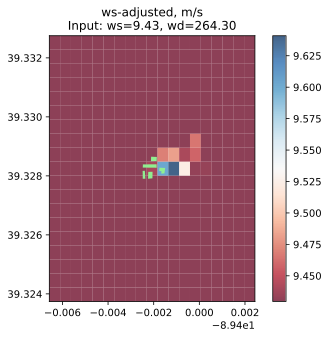

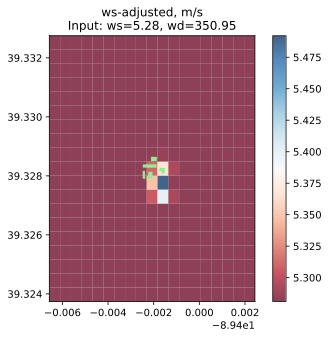

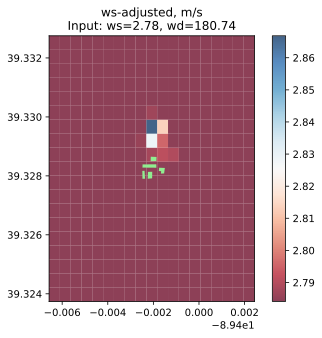

In [8]:
# New way of creating a summary dataframe, one quantity at a time; NO LOM

# Open the wind data "file"
# server endpoint, username, password is found via a config file
# f = h5pyd.File("/nrel/wtk-us.h5", 'r', bucket="nrel-pds-hsds") 

# Replace old files or not
overwrite = True

z_turbine =40  
obstacles_df = df_places   

output_dest = "../output/heatmap-180/"
if not os.path.exists(output_dest):
    os.makedirs(output_dest)

gridpoints_outside_polygons["ws"] = None
gridpoints_outside_polygons["wd"] = None
    
for time_step_id in time_step_ids:
    
    summary_df_cols = ["geometry", "ws-adjusted"]
    summary_df = pd.DataFrame(columns=summary_df_cols)
    summary_df_path = os.path.join(output_dest, "summary.csv")

    if os.path.exists(summary_df_path):
        if not overwrite:
            summary_df = pd.read_csv(summary_df_path)
    
    ### Computing
    
    for idx in gridpoints_outside_polygons.index:

        lat, lon = gridpoints_outside_polygons.at[idx, "geometry"].y, gridpoints_outside_polygons.at[idx, "geometry"].x

        lat_lon_label = str(lat) + "_" + str(lon)
        #print(lat_lon_label)

        ts_df_path = os.path.join(output_dest, lat_lon_label + ".csv")
        #print(ts_df_path)

        if os.path.exists(ts_df_path) and (not overwrite):
            print("This point was already processed. Skipping to the next one (overwrite flag is off)")
            continue

        time_period = str(atmospheric_df["datetime"][0]) + " - " + str(atmospheric_df["datetime"][len(atmospheric_df)-1])

        #gridpoints_outside_polygons.at[idx, "ws"] = ws.tolist()
        #gridpoints_outside_polygons.at[idx, "wd"] = theta.tolist()

        xy_turbine = [np.array([lon, lat])]

        # Instead of passing an entire input dataframe, here we pass in a single row
        predictions_df = \
            run_lom(atmospheric_df.iloc[[time_step_id]].reset_index(), obstacles_df, xy_turbine, z_turbine,
                   check_distance=True)

        predicte_ws = predictions_df.at[0, "ws-adjusted"]
        summary_df.loc[len(summary_df)] = [gridpoints_outside_polygons.at[idx, "geometry"], 
                                          predicte_ws]
        #print(predicte_ws)

    #display(summary_df)

    # Convert strings (possibly loaded from saved file) to shapely point objects
    # for idx in summary_df.index:
    #     el = summary_df["geometry"][idx]
    #     if type(el) == type("string"):
    #         summary_df["geometry"][idx] = shapely.wkt.loads(el)

    ### Visualizing
    
    # following code is based on example from: https://stackoverflow.com/questions/33282368/plotting-a-2d-heatmap
    x_, y_, z_ = [el.x for el in summary_df.geometry], \
                 [el.y for el in summary_df.geometry], \
                  summary_df["ws-adjusted"].tolist()

    # generate 2 2d grids for the x & y bounds
    y, x = np.array(y_).reshape(n_points,-1), np.array(x_).reshape(n_points,-1)
    z = np.array(z_).reshape(n_points,-1)
    # x and y are bounds, so z should be the value *inside* those bounds.
    # Therefore, remove the last value from the z array.
    z = z[:-1, :-1]
    z_min, z_max = z.min(), z.max()
    fig, ax = plt.subplots()
    c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max, alpha=0.75)

    input_ws = atmospheric_df.iloc[[time_step_id]]["ws"].tolist()[0]
    input_wd = atmospheric_df.iloc[[time_step_id]]["wd"].tolist()[0]
    ax.set_title('ws-adjusted, m/s\nInput: ws=%.2f, wd=%.2f' % (input_ws, input_wd))
    ax.set_aspect('equal')
    # set the limits of the plot to the limits of the data
    ax.axis([x.min(), x.max(), y.min(), y.max()])
    fig.colorbar(c, ax=ax)
    df_places.geometry.plot(color='lightgreen', ax=ax)
    plt.show()

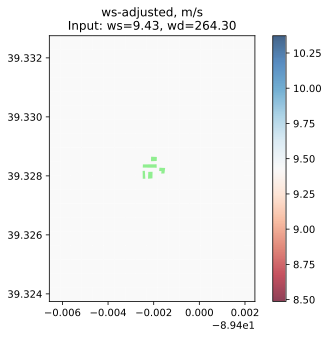

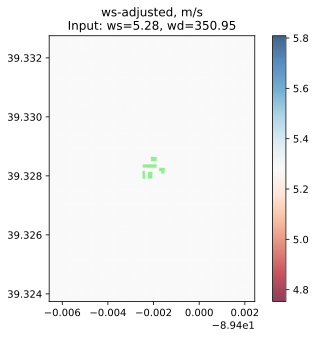

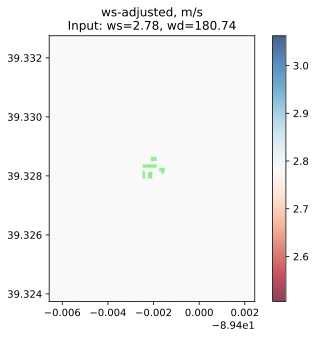

In [9]:
# New way of creating a summary dataframe, one quantity at a time; NO LOM

# Open the wind data "file"
# server endpoint, username, password is found via a config file
# f = h5pyd.File("/nrel/wtk-us.h5", 'r', bucket="nrel-pds-hsds") 

# Replace old files or not
overwrite = True

z_turbine =50  
obstacles_df = df_places   

output_dest = "../output/heatmap-180/"
if not os.path.exists(output_dest):
    os.makedirs(output_dest)

gridpoints_outside_polygons["ws"] = None
gridpoints_outside_polygons["wd"] = None
    
for time_step_id in time_step_ids:
    
    summary_df_cols = ["geometry", "ws-adjusted"]
    summary_df = pd.DataFrame(columns=summary_df_cols)
    summary_df_path = os.path.join(output_dest, "summary.csv")

    if os.path.exists(summary_df_path):
        if not overwrite:
            summary_df = pd.read_csv(summary_df_path)
    
    ### Computing
    
    for idx in gridpoints_outside_polygons.index:

        lat, lon = gridpoints_outside_polygons.at[idx, "geometry"].y, gridpoints_outside_polygons.at[idx, "geometry"].x

        lat_lon_label = str(lat) + "_" + str(lon)
        #print(lat_lon_label)

        ts_df_path = os.path.join(output_dest, lat_lon_label + ".csv")
        #print(ts_df_path)

        if os.path.exists(ts_df_path) and (not overwrite):
            print("This point was already processed. Skipping to the next one (overwrite flag is off)")
            continue

        time_period = str(atmospheric_df["datetime"][0]) + " - " + str(atmospheric_df["datetime"][len(atmospheric_df)-1])

        #gridpoints_outside_polygons.at[idx, "ws"] = ws.tolist()
        #gridpoints_outside_polygons.at[idx, "wd"] = theta.tolist()

        xy_turbine = [np.array([lon, lat])]

        # Instead of passing an entire input dataframe, here we pass in a single row
        predictions_df = \
            run_lom(atmospheric_df.iloc[[time_step_id]].reset_index(), obstacles_df, xy_turbine, z_turbine,
                   check_distance=True)

        predicte_ws = predictions_df.at[0, "ws-adjusted"]
        summary_df.loc[len(summary_df)] = [gridpoints_outside_polygons.at[idx, "geometry"], 
                                          predicte_ws]
        #print(predicte_ws)

    #display(summary_df)

    # Convert strings (possibly loaded from saved file) to shapely point objects
    # for idx in summary_df.index:
    #     el = summary_df["geometry"][idx]
    #     if type(el) == type("string"):
    #         summary_df["geometry"][idx] = shapely.wkt.loads(el)

    ### Visualizing
    
    # following code is based on example from: https://stackoverflow.com/questions/33282368/plotting-a-2d-heatmap
    x_, y_, z_ = [el.x for el in summary_df.geometry], \
                 [el.y for el in summary_df.geometry], \
                  summary_df["ws-adjusted"].tolist()

    # generate 2 2d grids for the x & y bounds
    y, x = np.array(y_).reshape(n_points,-1), np.array(x_).reshape(n_points,-1)
    z = np.array(z_).reshape(n_points,-1)
    # x and y are bounds, so z should be the value *inside* those bounds.
    # Therefore, remove the last value from the z array.
    z = z[:-1, :-1]
    z_min, z_max = z.min(), z.max()
    fig, ax = plt.subplots()
    c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max, alpha=0.75)

    input_ws = atmospheric_df.iloc[[time_step_id]]["ws"].tolist()[0]
    input_wd = atmospheric_df.iloc[[time_step_id]]["wd"].tolist()[0]
    ax.set_title('ws-adjusted, m/s\nInput: ws=%.2f, wd=%.2f' % (input_ws, input_wd))
    ax.set_aspect('equal')
    # set the limits of the plot to the limits of the data
    ax.axis([x.min(), x.max(), y.min(), y.max()])
    fig.colorbar(c, ax=ax)
    df_places.geometry.plot(color='lightgreen', ax=ax)
    plt.show()

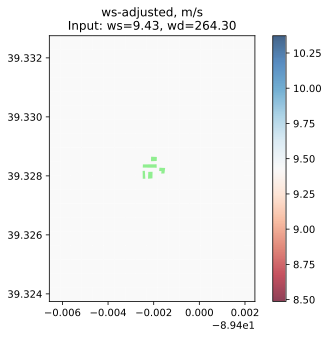

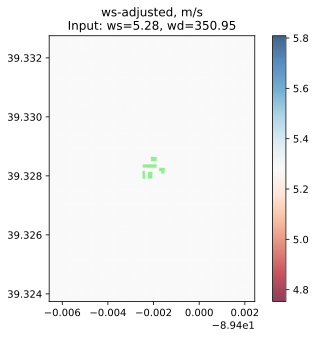

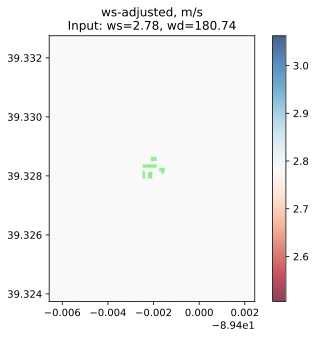

In [10]:
# New way of creating a summary dataframe, one quantity at a time; NO LOM

# Open the wind data "file"
# server endpoint, username, password is found via a config file
# f = h5pyd.File("/nrel/wtk-us.h5", 'r', bucket="nrel-pds-hsds") 

# Replace old files or not
overwrite = True

z_turbine =100  
obstacles_df = df_places   

output_dest = "../output/heatmap-180/"
if not os.path.exists(output_dest):
    os.makedirs(output_dest)

gridpoints_outside_polygons["ws"] = None
gridpoints_outside_polygons["wd"] = None
    
for time_step_id in time_step_ids:
    
    summary_df_cols = ["geometry", "ws-adjusted"]
    summary_df = pd.DataFrame(columns=summary_df_cols)
    summary_df_path = os.path.join(output_dest, "summary.csv")

    if os.path.exists(summary_df_path):
        if not overwrite:
            summary_df = pd.read_csv(summary_df_path)
    
    ### Computing
    
    for idx in gridpoints_outside_polygons.index:

        lat, lon = gridpoints_outside_polygons.at[idx, "geometry"].y, gridpoints_outside_polygons.at[idx, "geometry"].x

        lat_lon_label = str(lat) + "_" + str(lon)
        #print(lat_lon_label)

        ts_df_path = os.path.join(output_dest, lat_lon_label + ".csv")
        #print(ts_df_path)

        if os.path.exists(ts_df_path) and (not overwrite):
            print("This point was already processed. Skipping to the next one (overwrite flag is off)")
            continue

        time_period = str(atmospheric_df["datetime"][0]) + " - " + str(atmospheric_df["datetime"][len(atmospheric_df)-1])

        #gridpoints_outside_polygons.at[idx, "ws"] = ws.tolist()
        #gridpoints_outside_polygons.at[idx, "wd"] = theta.tolist()

        xy_turbine = [np.array([lon, lat])]

        # Instead of passing an entire input dataframe, here we pass in a single row
        predictions_df = \
            run_lom(atmospheric_df.iloc[[time_step_id]].reset_index(), obstacles_df, xy_turbine, z_turbine,
                   check_distance=True)

        predicte_ws = predictions_df.at[0, "ws-adjusted"]
        summary_df.loc[len(summary_df)] = [gridpoints_outside_polygons.at[idx, "geometry"], 
                                          predicte_ws]
        #print(predicte_ws)

    #display(summary_df)

    # Convert strings (possibly loaded from saved file) to shapely point objects
    # for idx in summary_df.index:
    #     el = summary_df["geometry"][idx]
    #     if type(el) == type("string"):
    #         summary_df["geometry"][idx] = shapely.wkt.loads(el)

    ### Visualizing
    
    # following code is based on example from: https://stackoverflow.com/questions/33282368/plotting-a-2d-heatmap
    x_, y_, z_ = [el.x for el in summary_df.geometry], \
                 [el.y for el in summary_df.geometry], \
                  summary_df["ws-adjusted"].tolist()

    # generate 2 2d grids for the x & y bounds
    y, x = np.array(y_).reshape(n_points,-1), np.array(x_).reshape(n_points,-1)
    z = np.array(z_).reshape(n_points,-1)
    # x and y are bounds, so z should be the value *inside* those bounds.
    # Therefore, remove the last value from the z array.
    z = z[:-1, :-1]
    z_min, z_max = z.min(), z.max()
    fig, ax = plt.subplots()
    c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max, alpha=0.75)

    input_ws = atmospheric_df.iloc[[time_step_id]]["ws"].tolist()[0]
    input_wd = atmospheric_df.iloc[[time_step_id]]["wd"].tolist()[0]
    ax.set_title('ws-adjusted, m/s\nInput: ws=%.2f, wd=%.2f' % (input_ws, input_wd))
    ax.set_aspect('equal')
    # set the limits of the plot to the limits of the data
    ax.axis([x.min(), x.max(), y.min(), y.max()])
    fig.colorbar(c, ax=ax)
    df_places.geometry.plot(color='lightgreen', ax=ax)
    plt.show()

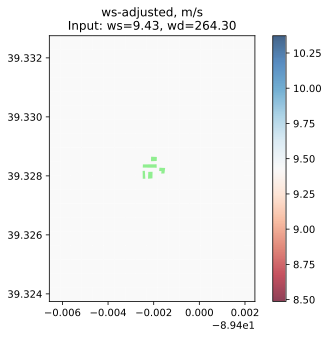

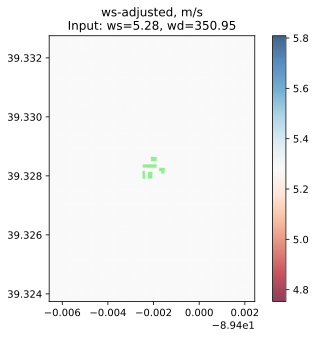

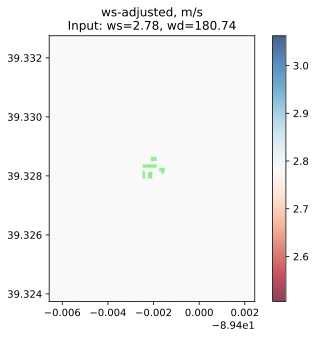

In [11]:
# New way of creating a summary dataframe, one quantity at a time; NO LOM

# Open the wind data "file"
# server endpoint, username, password is found via a config file
# f = h5pyd.File("/nrel/wtk-us.h5", 'r', bucket="nrel-pds-hsds") 

# Replace old files or not
overwrite = True

z_turbine =200  
obstacles_df = df_places   

output_dest = "../output/heatmap-180/"
if not os.path.exists(output_dest):
    os.makedirs(output_dest)

gridpoints_outside_polygons["ws"] = None
gridpoints_outside_polygons["wd"] = None
    
for time_step_id in time_step_ids:
    
    summary_df_cols = ["geometry", "ws-adjusted"]
    summary_df = pd.DataFrame(columns=summary_df_cols)
    summary_df_path = os.path.join(output_dest, "summary.csv")

    if os.path.exists(summary_df_path):
        if not overwrite:
            summary_df = pd.read_csv(summary_df_path)
    
    ### Computing
    
    for idx in gridpoints_outside_polygons.index:

        lat, lon = gridpoints_outside_polygons.at[idx, "geometry"].y, gridpoints_outside_polygons.at[idx, "geometry"].x

        lat_lon_label = str(lat) + "_" + str(lon)
        #print(lat_lon_label)

        ts_df_path = os.path.join(output_dest, lat_lon_label + ".csv")
        #print(ts_df_path)

        if os.path.exists(ts_df_path) and (not overwrite):
            print("This point was already processed. Skipping to the next one (overwrite flag is off)")
            continue

        time_period = str(atmospheric_df["datetime"][0]) + " - " + str(atmospheric_df["datetime"][len(atmospheric_df)-1])

        #gridpoints_outside_polygons.at[idx, "ws"] = ws.tolist()
        #gridpoints_outside_polygons.at[idx, "wd"] = theta.tolist()

        xy_turbine = [np.array([lon, lat])]

        # Instead of passing an entire input dataframe, here we pass in a single row
        predictions_df = \
            run_lom(atmospheric_df.iloc[[time_step_id]].reset_index(), obstacles_df, xy_turbine, z_turbine,
                   check_distance=True)

        predicte_ws = predictions_df.at[0, "ws-adjusted"]
        summary_df.loc[len(summary_df)] = [gridpoints_outside_polygons.at[idx, "geometry"], 
                                          predicte_ws]
        #print(predicte_ws)

    #display(summary_df)

    # Convert strings (possibly loaded from saved file) to shapely point objects
    # for idx in summary_df.index:
    #     el = summary_df["geometry"][idx]
    #     if type(el) == type("string"):
    #         summary_df["geometry"][idx] = shapely.wkt.loads(el)

    ### Visualizing
    
    # following code is based on example from: https://stackoverflow.com/questions/33282368/plotting-a-2d-heatmap
    x_, y_, z_ = [el.x for el in summary_df.geometry], \
                 [el.y for el in summary_df.geometry], \
                  summary_df["ws-adjusted"].tolist()

    # generate 2 2d grids for the x & y bounds
    y, x = np.array(y_).reshape(n_points,-1), np.array(x_).reshape(n_points,-1)
    z = np.array(z_).reshape(n_points,-1)
    # x and y are bounds, so z should be the value *inside* those bounds.
    # Therefore, remove the last value from the z array.
    z = z[:-1, :-1]
    z_min, z_max = z.min(), z.max()
    fig, ax = plt.subplots()
    c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max, alpha=0.75)

    input_ws = atmospheric_df.iloc[[time_step_id]]["ws"].tolist()[0]
    input_wd = atmospheric_df.iloc[[time_step_id]]["wd"].tolist()[0]
    ax.set_title('ws-adjusted, m/s\nInput: ws=%.2f, wd=%.2f' % (input_ws, input_wd))
    ax.set_aspect('equal')
    # set the limits of the plot to the limits of the data
    ax.axis([x.min(), x.max(), y.min(), y.max()])
    fig.colorbar(c, ax=ax)
    df_places.geometry.plot(color='lightgreen', ax=ax)
    plt.show()

### Below: heatmap vis for energy produced over entire studied period 

In [12]:
# New way of creating a summary dataframe, one quantity at a time; NO LOM

# Open the wind data "file"
# server endpoint, username, password is found via a config file
# f = h5pyd.File("/nrel/wtk-us.h5", 'r', bucket="nrel-pds-hsds") 

# Replace old files or not
overwrite = True

z_turbine = 40   
obstacles_df = df_places   

output_dest = "../output/heatmap-180/"
if not os.path.exists(output_dest):
    os.makedirs(output_dest)

gridpoints_outside_polygons["ws"] = None
gridpoints_outside_polygons["wd"] = None

summary_df_cols = ["geometry", "time_period", 
                   "khw_without_lom", "khw_with_lom", "kwh_delta", 
                   "ts_file_path"]
summary_df = pd.DataFrame(columns=summary_df_cols)
summary_df_path = os.path.join(output_dest, "summary.csv")

if os.path.exists(summary_df_path):
    if not overwrite:
        summary_df = pd.read_csv(summary_df_path)

# For testing outside of NREL, load in data from a file
# This isn't quite the same as running getData() for each of the heatmap points
# (because spatial interpolation will change the values slighly)
# but it is close enough for the first pass

atmospheric_df = pd.read_csv("../data/180_heatmap_atmospheric_df.csv") 
    
for idx in gridpoints_outside_polygons.index:
    
    lat, lon = gridpoints_outside_polygons.at[idx, "geometry"].y, gridpoints_outside_polygons.at[idx, "geometry"].x
    print("Estimating for: (%.3f, %.3f)" % (lat, lon))
    
    lat_lon_label = str(lat) + "_" + str(lon)
    #print(lat_lon_label)
    
    ts_df_path = os.path.join(output_dest, lat_lon_label + ".csv")
    #print(ts_df_path)
    
    if os.path.exists(ts_df_path) and (not overwrite):
        print("This point was already processed. Skipping to the next one (overwrite flag is off)")
        continue

    # atmospheric_df = getData(f, 
    #                          lat, 
    #                          lon, 
    #                          z_turbine, "IDW", True, 
    #                          start_time_idx=0, end_time_idx=4000, time_stride=1) # 0, 4380, 1) # year: 8760; Quick test: 0, 2000, 200)
   
    # For testing outside of NREL, load in data from a file
    # This isn't quite the same as running getData() for each of the heatmap points
    # (because spatial interpolation will change the values slighly)
    # but it is close enough for the first pass
    
    # atmospheric_df.to_csv("../data/180_heatmap_atmospheric_df.csv", index=False)
    # break 
    
    # print("Done with data fetching for the point.")
    
    time_period = str(atmospheric_df["datetime"][0]) + " - " + str(atmospheric_df["datetime"][len(atmospheric_df)-1])
    
    #gridpoints_outside_polygons.at[idx, "ws"] = ws.tolist()
    #gridpoints_outside_polygons.at[idx, "wd"] = theta.tolist()
    
    xy_turbine = [np.array([lon, lat])]
    
    predictions_df = \
        run_lom(atmospheric_df, obstacles_df, xy_turbine, z_turbine,
               check_distance=True)
    
    print("Avg. ws deficit (m/s):", (predictions_df["ws"] - predictions_df["ws-adjusted"]).mean())
    
    time_powerOutput0 = time.time()

    kw_ts_with_lom, above_curve, below_curve, above_curve_list, below_curve_list = \
        estimate_power_output(predictions_df, atmospheric_df['temp'], atmospheric_df['pres'],
                              ws_column="ws-adjusted")  
    kwh_total_with_lom = kw_ts_with_lom.sum()
    
    kw_ts_without_lom, above_curve, below_curve, above_curve_list, below_curve_list = \
        estimate_power_output(predictions_df, atmospheric_df['temp'], atmospheric_df['pres'],
                              ws_column="ws")  
    kwh_total_without_lom = kw_ts_without_lom.sum()
    
    print("Total kWh (with and without LOM):", kwh_total_with_lom, kwh_total_without_lom)
        
    summary_df.loc[len(summary_df)] = [gridpoints_outside_polygons.at[idx, "geometry"],
                                       time_period,
                                       kwh_total_without_lom,
                                       kwh_total_with_lom,
                                       kwh_total_without_lom - kwh_total_with_lom,
                                       ts_df_path]
    
    ts_df = pd.DataFrame({"datetime": atmospheric_df["datetime"],
                          "ws": atmospheric_df["ws"],
                          "wd": atmospheric_df["wd"],
                          "ws-adjusted": predictions_df["ws-adjusted"],
                          "kw_ts_without_lom": kw_ts_without_lom,
                          "kw_ts_with_lom": kw_ts_with_lom})
    
    summary_df.to_csv(summary_df_path, index=False)
    ts_df.to_csv(ts_df_path, index=False)
                                           
    # break

Estimating for: (39.324, -89.407)
Avg. ws deficit (m/s): 0.0
Total kWh (with and without LOM): 8900.99438188643 8900.99438188643
Estimating for: (39.324, -89.406)
Avg. ws deficit (m/s): 0.0
Total kWh (with and without LOM): 8900.99438188643 8900.99438188643
Estimating for: (39.324, -89.406)
Avg. ws deficit (m/s): 0.0
Total kWh (with and without LOM): 8900.99438188643 8900.99438188643
Estimating for: (39.324, -89.405)
Avg. ws deficit (m/s): 0.0
Total kWh (with and without LOM): 8900.99438188643 8900.99438188643
Estimating for: (39.324, -89.405)
Avg. ws deficit (m/s): 0.0
Total kWh (with and without LOM): 8900.99438188643 8900.99438188643
Estimating for: (39.324, -89.404)
Avg. ws deficit (m/s): 0.0
Total kWh (with and without LOM): 8900.99438188643 8900.99438188643
Estimating for: (39.324, -89.404)
Avg. ws deficit (m/s): 0.0
Total kWh (with and without LOM): 8900.99438188643 8900.99438188643
Estimating for: (39.324, -89.403)
Avg. ws deficit (m/s): 0.0
Total kWh (with and without LOM): 89

In [13]:
summary_df

,geometry,time_period,khw_without_lom,khw_with_lom,kwh_delta,ts_file_path
0,POINT (-89.4065737583436 39.32374224859211),2007-01-01 00:00:00 - 2007-06-16 16:00:00,8900.994382,8900.994382,0.0,../output/heatmap-180/39.32374224859211_-89.40...
1,POINT (-89.4060995999747 39.32374224859211),2007-01-01 00:00:00 - 2007-06-16 16:00:00,8900.994382,8900.994382,0.0,../output/heatmap-180/39.32374224859211_-89.40...
2,POINT (-89.40562544160581 39.32374224859211),2007-01-01 00:00:00 - 2007-06-16 16:00:00,8900.994382,8900.994382,0.0,../output/heatmap-180/39.32374224859211_-89.40...
3,POINT (-89.4051512832369 39.32374224859211),2007-01-01 00:00:00 - 2007-06-16 16:00:00,8900.994382,8900.994382,0.0,../output/heatmap-180/39.32374224859211_-89.40...
4,POINT (-89.40467712486802 39.32374224859211),2007-01-01 00:00:00 - 2007-06-16 16:00:00,8900.994382,8900.994382,0.0,../output/heatmap-180/39.32374224859211_-89.40...
...,...,...,...,...,...,...
395,POINT (-89.39946138281016 39.33275125760112),2007-01-01 00:00:00 - 2007-06-16 16:00:00,8900.994382,8900.994382,0.0,../output/heatmap-180/39.33275125760112_-89.39...
396,POINT (-89.39898722444127 39.33275125760112),2007-01-01 00:00:00 - 2007-06-16 16:00:00,8900.994382,8900.994382,0.0,../output/heatmap-180/39.33275125760112_-89.39...
397,POINT (-89.39851306607237 39.33275125760112),2007-01-01 00:00:00 - 2007-06-16 16:00:00,8900.994382,8900.994382,0.0,../output/heatmap-180/39.33275125760112_-89.39...
398,POINT (-89.39803890770348 39.33275125760112),2007-01-01 00:00:00 - 2007-06-16 16:00:00,8900.994382,8900.994382,0.0,../output/heatmap-180/39.33275125760112_-89.39...


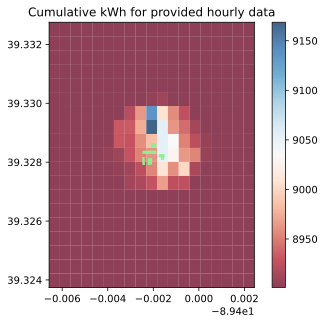

In [14]:
# Energy estimates: visualize as a heatmap

# Convert strings (possibly loaded from saved file) to shapely point objects
for idx in summary_df.index:
    el = summary_df["geometry"][idx]
    if type(el) == type("string"):
        summary_df["geometry"][idx] = shapely.wkt.loads(el)

# following code is based on example from: https://stackoverflow.com/questions/33282368/plotting-a-2d-heatmap

x_, y_, z_ = [el.x for el in summary_df.geometry], \
             [el.y for el in summary_df.geometry], \
              summary_df.khw_with_lom.tolist()

# generate 2 2d grids for the x & y bounds
y, x = np.array(y_).reshape(n_points,-1), np.array(x_).reshape(n_points,-1)

z = np.array(z_).reshape(n_points,-1)
# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
z = z[:-1, :-1]
z_min, z_max = np.abs(z).min(), np.abs(z).max()

fig, ax = plt.subplots()

c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max, alpha=0.75)
#ax.set_title('Cumulative kWh for Bergey 10 at 40m for 6 months (with obstacle LOM)')

ax.set_title('Cumulative kWh for provided hourly data')

# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

df_places.geometry.plot(color='lightgreen', ax=ax)
plt.show()